In [1]:
%matplotlib inline

import pickle
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
import os

dataset = pd.read_csv('dataAccelGyroX2.txt')
dataset.head()

,-5700,6888,12384,420,-5707,-1692,-5980,6384,12776,794,...,1594,-8823,-4679,-2184,14992,1132,1294,-4062,-1328,0
0,-5980,6384,12776,794,-1036,-1222,-7348,7424,13836,730,...,1294,-4062,-1328,-1380,18304,1952,-906,-2616,1565,0
1,-7348,7424,13836,730,-2235,389,-5584,6744,13868,109,...,-906,-2616,1565,-1512,16124,2680,-753,2345,2680,0
2,-5584,6744,13868,109,-2177,-1112,-6224,6480,14060,-137,...,-753,2345,2680,-1576,14240,1920,-1713,550,3010,0
3,-6224,6480,14060,-137,1387,593,-6492,6288,13244,941,...,-1713,550,3010,-932,14812,2484,-1549,989,1968,0
4,-6492,6288,13244,941,-1288,-1612,-6760,6200,13648,421,...,-1549,989,1968,-1524,16360,2480,-677,3366,3260,0


In [2]:
# Spliting the points and the labels
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [4]:
window = 30 # depends on time window
epochs = 15
batch_size = 128
acc_vec_dim = 6 # depends on how many sensors used

class_names = list(set(y))
num_class = len(class_names)

X_testg = X_test.reshape(X_test.shape[0], window, acc_vec_dim)
X_traing = X_train.reshape(X_train.shape[0], window, acc_vec_dim)
print(X_traing.shape)
print(X_testg.shape)
print(X_traing[0])

(625060, 30, 6)
(156266, 30, 6)
[[16464  1020  2476  -198  -480  -115]
 [17348  1124  2512     4  -388  -338]
 [16564  1244  2584  -322  -537   -51]
 [16436  1268  2452  -280  -400  -254]
 [16432   988  2440  -305  -222   -89]
 [16368  1132  2468  -283  -431   -49]
 [16400   988  2516  -198  -414   -70]
 [16460  1196  2656  -254  -353   -85]
 [16548  1252  2516  -356  -432  -105]
 [16504  1100  2352  -282  -370  -192]
 [16560  1172  2500  -267  -306   -95]
 [16616  1040  2372  -222  -423  -113]
 [17256  1060  2460   -65  -563  -262]
 [16748  1268  2624  -319  -391  -107]
 [16416  1140  2420  -259  -378  -124]
 [16588  1088  2676  -259  -347  -166]
 [16736  1160  2464  -331  -411   -72]
 [16360  1300  2540  -215  -332   -84]
 [16556  1040  2320  -205  -294  -116]
 [16228  1240  2636  -325  -384   -10]
 [16576  1188  2276  -176  -205  -166]
 [16440  1128  2556  -148  -345  -221]
 [16636   996  2688  -319  -417   -38]
 [16520  1040  2376  -416  -366   -22]
 [16420   988  2332  -260  -240 

In [ ]:
model = Sequential()
model.add(LSTM(512,dropout=0.15,recurrent_dropout=0.15,input_shape=(window, acc_vec_dim)))
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))
print(model.summary())

checkpoint_path = "trainingAG_LSTM5/cp.ckpt" #MAKE SURE CHECK SINI DULU............................
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#model.load_weights(checkpoint_path)

history = model.fit(X_traing, y_train,
                        batch_size=batch_size,
                        epochs=15,
                        verbose=1,
                        validation_data=(X_testg, y_test),
                        callbacks=[cp_callback])

In [12]:
preds = model.predict(X_testg)
predsList = preds.tolist()
predo = []
for valList in predsList:
    predo.append(valList.index(max(valList)))
predo = np.asarray(predo)

from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, predo)
print(conf_matrix)

class_report = classification_report(y_test, predo)
print(class_report)

[[6698  132  337]
 [ 139 7070  117]
 [ 468  312 2593]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7167
           1       0.94      0.97      0.95      7326
           2       0.85      0.77      0.81      3373

    accuracy                           0.92     17866
   macro avg       0.90      0.89      0.90     17866
weighted avg       0.91      0.92      0.91     17866



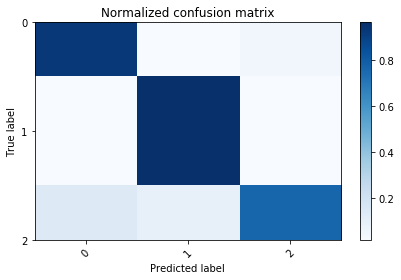

Classes:  [0, 1, 2]


In [13]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
plot_confusion_matrix(conf_matrix, classes=sorted(class_names), normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print('Classes: ', sorted(class_names))

1


Text(0.5, 1.0, 'An example of 1min acceleration data')

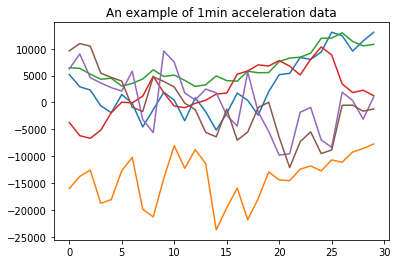

In [16]:
import matplotlib.pyplot as plt

print(y_train[0])
plt.plot(X_traing[0])
plt.title("An example of 1min acceleration data")

0


Text(0.5, 1.0, 'An example of 1min acceleration data')

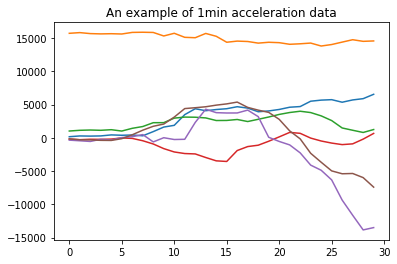

In [17]:
print(y_train[35000])
plt.plot(X_traing[35000])
plt.title("An example of 1min acceleration data")

1


Text(0.5, 1.0, 'An example of 1min acceleration data')

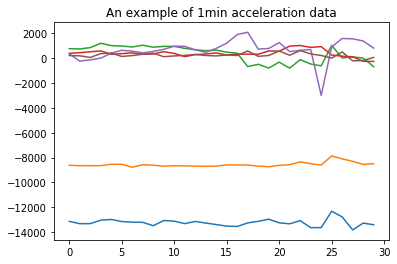

In [18]:
print(y_train[45000])
plt.plot(X_traing[45000])
plt.title("An example of 1min acceleration data")

1


Text(0.5, 1.0, 'An example of 1min acceleration data')

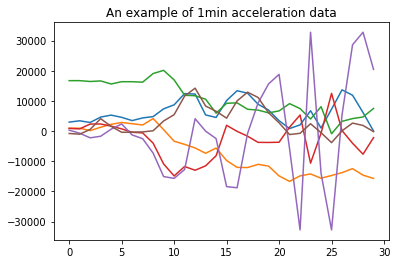

In [19]:
print(y_train[70000])
plt.plot(X_traing[70000])
plt.title("An example of 1min acceleration data")

0


Text(0.5, 1.0, 'An example of 1min acceleration data')

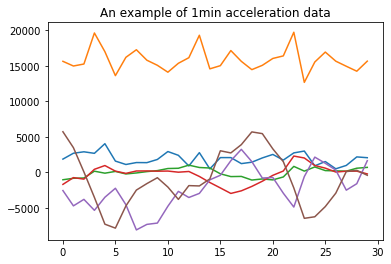

In [22]:
print(y_train[25300])
plt.plot(X_traing[25300])
plt.title("An example of 1min acceleration data")

2


Text(0.5, 1.0, 'An example of 1min acceleration data')

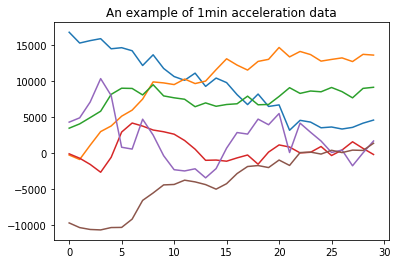

In [23]:
print(y_train[300])
plt.plot(X_traing[300])
plt.title("An example of 1min acceleration data")

0


Text(0.5, 1.0, '3 sec data')

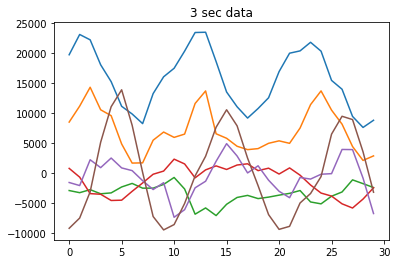

In [42]:
print(y_train[90])
plt.plot(X_traing[90])
plt.title("3 sec data")

Text(0.5, 1.0, '3 sec data')

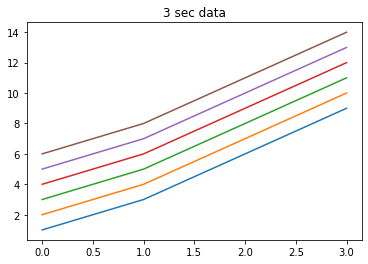

In [41]:
# biru, kuning, ijau - acc
# maroon, purple, brown - gyro
plt.plot([[1,2,3,4,5,6],[3,4,5,6,7,8],[6,7,8,9,10,11],[9,10,11,12,13,14]])
plt.title("3 sec data")